* Install `pcdet` library and then generate the data infos by running the following command: 
```python 
python -m pcdet.datasets.kitti.kitti_dataset create_kitti_infos tools/cfgs/dataset_configs/kitti_dataset.yaml
```

In [1]:
from tqdm import tqdm

In [2]:
import sys
import yaml
from pathlib import Path
from easydict import EasyDict
import numpy as np

from pcdet.datasets import KittiDataset

import pandas_profiling
import pandas as pd

In [3]:
dataset_cfg_dir = '/home/farzad/OpenPCDet/tools/cfgs/dataset_configs/kitti_dataset.yaml'
pcdet_root_dir = Path('/home/farzad/OpenPCDet')
class_names = ['Pedestrian', 'Car']

In [4]:
dataset_cfg = EasyDict(yaml.load(open(dataset_cfg_dir)))
data_path = pcdet_root_dir / 'data' / 'kitti'
save_path = pcdet_root_dir / 'data' / 'kitti'

<ipython-input-4-e660d07e3510>:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dataset_cfg = EasyDict(yaml.load(open(dataset_cfg_dir)))


In [5]:
kitti = KittiDataset(dataset_cfg=dataset_cfg, class_names=class_names, root_path=data_path)
infos = kitti.get_infos();

In [7]:
per_img_infos = []
per_obj_infos = []

for info in tqdm(infos):
    
    annos = info['annos']
    num_gts = annos['gt_boxes_lidar'].shape[0]
    
    lidar_idx = info['point_cloud']['lidar_idx']
    
    img_info = {}
    img_info['lidar_idx'] = lidar_idx
    img_info['num_gts'] = num_gts
    img_info['img_height'] = info['image']['image_shape'][0]
    img_info['img_width'] = info['image']['image_shape'][1]
        
    for i in range(num_gts):
        obj_info = {}
        obj_info['lidar_idx'] = lidar_idx
        
        
        for key, val in annos.items():
            if val.ndim == 2:  # split columns with 2D elements
                for j in range(val.shape[-1]):
                    new_key = key + f'_{j}'
                    obj_info[new_key] = val[i, j]
            else:
                obj_info[key] = val[i]
            
        per_obj_infos.append(obj_info)
    
    per_img_infos.append(img_info)

100%|██████████| 17014/17014 [00:00<00:00, 22233.45it/s]


In [42]:
per_img_infos_pd = pd.DataFrame.from_dict(per_img_infos)
per_obj_infos_pd = pd.DataFrame.from_dict(per_obj_infos)
new_colnames = ['lidar_idx', 'name', 'truncated', 'occluded', 'alpha (radian)', 'bbox_left (pixel)',
                'bbox_top (pixel)', 'bbox_right (pixel)', 'bbox_bottom (pixel)', 'dimensions_height (meters)',
                'dimensions_width (meters)', 'dimensions_length (meters)', 'location_x (meter)',
                'rotation_y (meters)', 'rotation_z (meters)', 'rotation_y', 'score', 'difficulty', 'index',
                'gt_boxes_lidar_0', 'gt_boxes_lidar_1', 'gt_boxes_lidar_2', 'gt_boxes_lidar_3', 'gt_boxes_lidar_4',
                'gt_boxes_lidar_5', 'gt_boxes_lidar_6', 'num_points_in_gt']
per_obj_infos_pd.columns = new_colnames
per_obj_infos_pd = per_obj_infos_pd.drop(columns=['lidar_idx', 'index'])
report_img = pandas_profiling.ProfileReport(per_img_infos_pd, minimal=True)
report_obj = pandas_profiling.ProfileReport(per_obj_infos_pd, minimal=True)

# report_img.to_file("./dataset_reports/carla_kitti_22k_40removal_less25hremoval_per_img.html")
# report_obj.to_file("./dataset_reports/carla_kitti_22k_40removal_less25hremoval_per_obj.html")

In [43]:
area = per_obj_infos_pd['dimensions_height (meters)'] * per_obj_infos_pd['dimensions_width (meters)']
per_obj_infos_pd['area (meter^2)'] = area

In [46]:
width = per_obj_infos_pd['bbox_right (pixel)'] - per_obj_infos_pd['bbox_left (pixel)']
height = per_obj_infos_pd['bbox_bottom (pixel)'] - per_obj_infos_pd['bbox_top (pixel)']
per_obj_infos_pd['dimensions_height (pixels)'] = height
per_obj_infos_pd['area (pixel^2)'] = height * width

In [156]:
per_obj_infos_pd

,name,truncated,occluded,alpha (radian),bbox_left (pixel),bbox_top (pixel),bbox_right (pixel),bbox_bottom (pixel),dimensions_height (meters),dimensions_width (meters),...,gt_boxes_lidar_1,gt_boxes_lidar_2,gt_boxes_lidar_3,gt_boxes_lidar_4,gt_boxes_lidar_5,gt_boxes_lidar_6,num_points_in_gt,area (meter^2),dimensions_height (pixels),area (pixel^2)
0,Pedestrian,0.00,2.0,2.79,839.0,203.0,856.0,231.0,0.50,1.10,...,-8.91,-1.020,0.50,0.50,1.10,-4.680796,0,0.5500,28.0,476.0
1,Pedestrian,0.00,0.0,-1.70,448.0,185.0,468.0,226.0,0.68,1.86,...,7.52,-0.640,0.68,0.68,1.86,-0.120796,17,1.2648,41.0,820.0
2,Car,0.28,0.0,-1.58,473.0,209.0,773.0,384.0,3.81,1.48,...,0.01,-0.960,3.81,1.97,1.48,-0.000796,1907,5.6388,175.0,52500.0
3,Car,0.00,1.0,-1.57,560.0,180.0,686.0,301.0,4.60,1.85,...,0.01,-0.755,4.60,1.93,1.85,-0.000796,155,8.5100,121.0,15246.0
4,Car,0.00,0.0,1.47,537.0,195.0,575.0,221.0,4.19,1.47,...,4.05,-0.955,4.19,1.82,1.47,-3.150796,44,6.1593,26.0,988.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83047,Car,0.00,0.0,0.92,93.0,193.0,409.0,381.0,4.61,1.67,...,4.19,-0.855,4.61,2.24,1.67,-2.900796,1301,7.6987,188.0,59408.0
83048,Car,0.00,0.0,-1.25,573.0,196.0,667.0,242.0,4.90,1.51,...,-0.02,-0.945,4.90,2.13,1.51,-0.320796,168,7.3990,46.0,4324.0
83049,Pedestrian,0.00,0.0,-1.72,703.0,186.0,716.0,218.0,0.68,1.86,...,-5.04,-0.620,0.68,0.68,1.86,0.019204,9,1.2648,32.0,416.0
83050,Car,0.00,0.0,1.46,532.0,194.0,573.0,220.0,4.51,1.52,...,4.32,-0.930,4.51,2.01,1.52,-3.130796,49,6.8552,26.0,1066.0


In [160]:
sep_dfs = {}
for (name, df) in per_obj_infos_pd.groupby('name'):
#     pd_prof = pandas_profiling.ProfileReport(df, minimal=True)
    sep_dfs[name] = df
#     pd_prof.to_file("./dataset_reports/carla_kitti_22k_40removal_less25hremoval_per_obj_{}_only.html".format(name))

In [188]:
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()


<IPython.core.display.Javascript object>


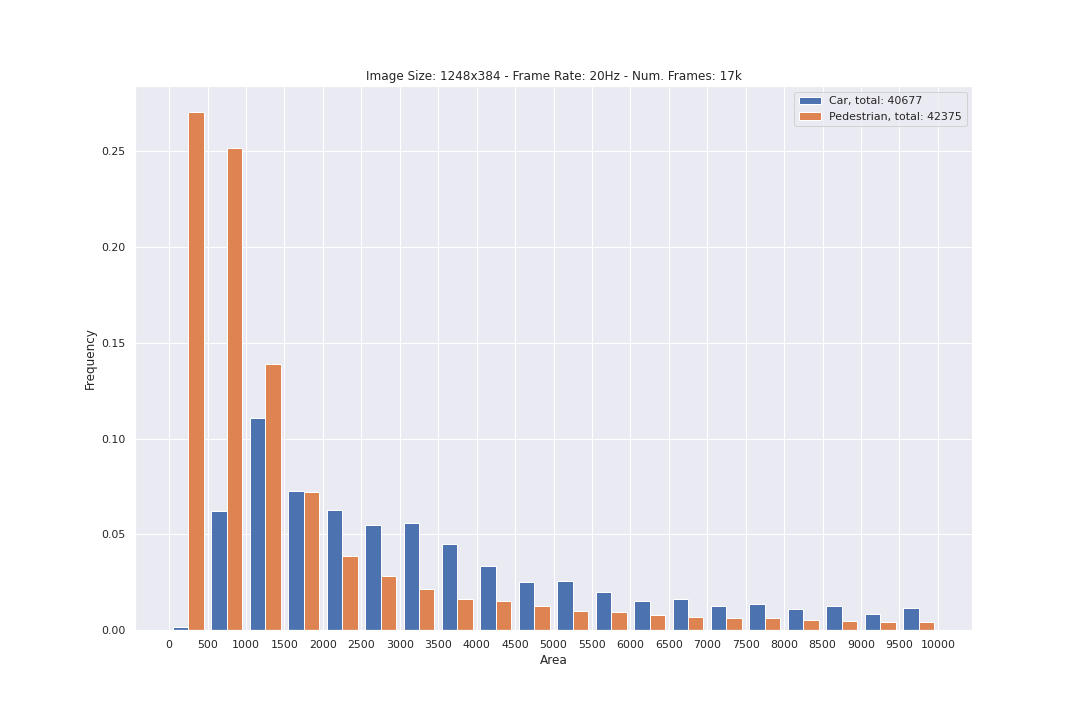

In [202]:
f, ax = plt.subplots(1,1,figsize=(15,10))
vectors = [df['area (pixel^2)'].to_numpy() for df in sep_dfs.values()]
vec_weights = [[] for x in range(len(vectors))]
x_range = (0, 10000)
labels = [k +  ', total: {}'.format(len(v)) for k, v in sep_dfs.items()]
for i in range(len(vectors)):
    if 0 < len(vectors[i]):
        vec_weights[i] = np.ones(len(vectors[i])) / len(vectors[i])
    else:
        vec_weights[i] = 0

# plt.gca().yaxis.set_major_formatter(PercentFormatter(1));
arr, bins, patches = plt.hist(vectors, bins=20, label=labels, weights=vec_weights, range=x_range);
ax.set_xticks(bins)
# ax.set(xlabel='Height')
ax.set(xlabel='Area')
ax.set(ylabel='Frequency')

ax.set_title('Image Size: 1248x384 - Frame Rate: 20Hz - Num. Frames: 17k')
plt.legend()
plt.savefig("hist_car_ped_area.png")
# plt.savefig("hist_car_ped_height.png")
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
